In [161]:
import torch
import torch.nn as nn
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
import torch_geometric.transforms as T
from torch_geometric.nn import MessagePassing, global_max_pool
from torch_geometric.utils import add_self_loops, degree
import torch.nn.functional as F
import geoopt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [162]:
from manifolds import PoincareBall
from utils import tanh, artanh

In [163]:
dataset = TUDataset(root='data/TUDataset', name='PROTEINS', transform=T.NormalizeFeatures())
dataset

PROTEINS(1113)

In [164]:
from collections import Counter

labels = [data.y.item() for data in dataset]
class_counts = Counter(labels)

print(f"Number of enzymes: {class_counts[1]}")
print(f"Number of non-enzymes: {class_counts[0]}")

Number of enzymes: 450
Number of non-enzymes: 663


In [165]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [166]:
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

C:\Users\sutig\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [167]:
num_features = dataset.num_features
num_classes = dataset.num_classes
print(f"Number of features: {num_features} \nNumber of classes: {num_classes}")

Number of features: 3 
Number of classes: 2


In [168]:
hyperbolic_model = PoincareBall(dimension=3)

In [169]:
class HyperbolicReLU(nn.Module):
    def __init__(self, hyperbolic_model):
        super(HyperbolicReLU, self).__init__()
        self.hyperbolic_model = hyperbolic_model
        
    def forward(self, x):
        x = self.hyperbolic_model.log_map0(x)
        x = F.relu(x)
        x = self.hyperbolic_model.exp_map0(x)
        return x

In [170]:
class HyperbolicLayerNorm(nn.Module):
    def __init__(self, num_features, hyperbolic_model):
        super(HyperbolicLayerNorm, self).__init__()
        self.hyperbolic_model = hyperbolic_model
        self.norm = nn.LayerNorm(num_features)

    def forward(self, x):
        x = self.hyperbolic_model.log_map0(x)
        x = self.norm(x)
        x = self.hyperbolic_model.exp_map0(x)
        return x

In [171]:
class HyperbolicGCNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels, hyperbolic_model):
        super(HyperbolicGCNLayer, self).__init__(aggr='add')
        self.hyperbolic_model = hyperbolic_model
        self.weight = nn.Parameter(torch.Tensor(in_channels, out_channels))
        self.bias = nn.Parameter(torch.Tensor(out_channels))
        self.ln = HyperbolicLayerNorm(out_channels, hyperbolic_model)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        nn.init.zeros_(self.bias)
        
    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        x = self.hyperbolic_model.mobius_matrix_vector_mul(self.weight, x)
        x = self.propagate(edge_index, x=x, norm=norm)
        return x

    def message(self, x_j, norm):
         return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        aggr_out = self.hyperbolic_model.mobius_add(aggr_out, self.bias)
        aggr_out = self.ln(aggr_out)
        aggr_out = tanh(aggr_out)
        return self.hyperbolic_model.project(aggr_out)


In [172]:
class HyperbolicGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(HyperbolicGCN, self).__init__()
        self.conv1 = HyperbolicGCNLayer(in_channels, hidden_channels, hyperbolic_model)
        self.conv2 = HyperbolicGCNLayer(hidden_channels, hidden_channels, hyperbolic_model)
        self.conv3 = HyperbolicGCNLayer(hidden_channels, hidden_channels, hyperbolic_model)
        self.conv4 = HyperbolicGCNLayer(hidden_channels, hidden_channels, hyperbolic_model)
        self.conv5 = HyperbolicGCNLayer(hidden_channels, hidden_channels, hyperbolic_model)
        self.relu = HyperbolicReLU(hyperbolic_model)
        self.global_pool = global_max_pool
        self.fc1 = nn.Linear(hidden_channels, hidden_channels // 2)
        self.fc2 = nn.Linear(hidden_channels // 2, out_channels)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)
        x = self.conv4(x, edge_index)
        x = self.conv5(x, edge_index)
        x = self.global_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=-1)
        return x

In [173]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = HyperbolicGCN(in_channels=num_features, hidden_channels=128, out_channels=num_classes).to(device)
optimizer = geoopt.optim.RiemannianAdam(model.parameters(), lr=2e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(loader):
    model.eval()
    correct = 0
    all_preds = []
    all_labels = []
    for data in loader:
        data = data.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        correct += pred.eq(data.y).sum().item()
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())
    return correct / len(loader.dataset), all_preds, all_labels

best_val_acc = 0.0
best_model_path = 'best_hyperbolic_gcn.pth'
for epoch in range(50):
    loss = train()
    train_acc, _, _ = evaluate(train_loader)
    val_acc, _, _ = evaluate(val_loader)
    print(f"Epoch {epoch+1}: Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        

Epoch 1: Loss: 0.6758, Train Acc: 0.5933, Val Acc: 0.5946
Epoch 2: Loss: 0.6653, Train Acc: 0.5933, Val Acc: 0.5946
Epoch 3: Loss: 0.6489, Train Acc: 0.5933, Val Acc: 0.5946
Epoch 4: Loss: 0.6299, Train Acc: 0.5933, Val Acc: 0.5946
Epoch 5: Loss: 0.6159, Train Acc: 0.5933, Val Acc: 0.5946
Epoch 6: Loss: 0.6020, Train Acc: 0.6809, Val Acc: 0.6216
Epoch 7: Loss: 0.5954, Train Acc: 0.7449, Val Acc: 0.6757
Epoch 8: Loss: 0.5841, Train Acc: 0.7438, Val Acc: 0.6937
Epoch 9: Loss: 0.5734, Train Acc: 0.7494, Val Acc: 0.6847
Epoch 10: Loss: 0.5701, Train Acc: 0.7506, Val Acc: 0.6847
Epoch 11: Loss: 0.5695, Train Acc: 0.7506, Val Acc: 0.6847
Epoch 12: Loss: 0.5570, Train Acc: 0.7416, Val Acc: 0.7207
Epoch 13: Loss: 0.5562, Train Acc: 0.7461, Val Acc: 0.7207
Epoch 14: Loss: 0.5496, Train Acc: 0.7506, Val Acc: 0.6937
Epoch 15: Loss: 0.5445, Train Acc: 0.7506, Val Acc: 0.7117
Epoch 16: Loss: 0.5492, Train Acc: 0.7449, Val Acc: 0.7297
Epoch 17: Loss: 0.5399, Train Acc: 0.7494, Val Acc: 0.7027
Epoch 

In [174]:
test_model = HyperbolicGCN(in_channels=num_features, hidden_channels=128, out_channels=num_classes).to(device)
test_model.load_state_dict(torch.load(best_model_path))
test_acc, test_preds, test_labels = evaluate(test_loader)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Test Accuracy: 79.46%


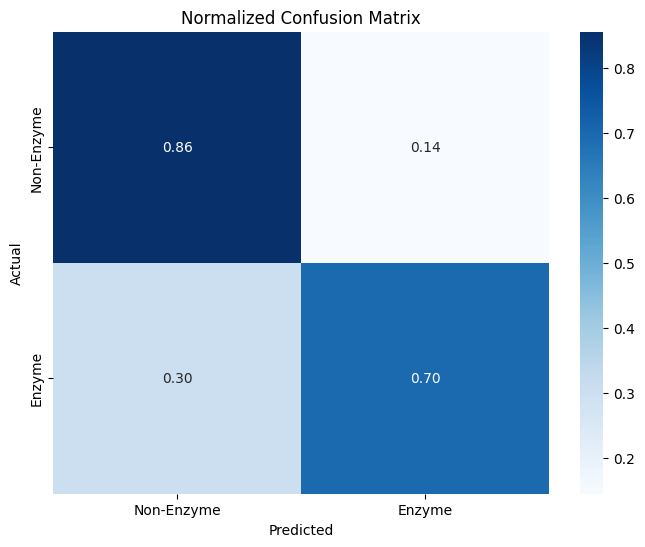

In [175]:
cm = confusion_matrix(test_labels, test_preds, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Non-Enzyme', 'Enzyme'], yticklabels=['Non-Enzyme', 'Enzyme'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix")
plt.show()

In [176]:
print("Classification Report:")
print(classification_report(test_labels, test_preds))

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        69
           1       0.75      0.70      0.72        43

    accuracy                           0.79       112
   macro avg       0.78      0.78      0.78       112
weighted avg       0.79      0.79      0.79       112

